In [6]:
import os
import sys
import glob

try:
    sys.path.append(glob.glob('../carla/PythonAPI/carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

import carla
import hydra

from omegaconf import DictConfig, OmegaConf
from hydra.core.config_store import ConfigStore

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from core.pgm import PGM
from utils.weather import Weather
from schemas.pgm_schema import PGMModel
from schemas.weather_schema import WeatherSchema, SunSchema
from schemas.variables_schema import VariablesSchema, VariableSchema
from schemas.config_schema import ConfigSchema

In [29]:
cs = ConfigStore.instance()
cs.store(group="weather", name="base_weather_model", node=WeatherSchema)
cs.store(group="weather/sun", name="base_sun_model", node=SunSchema)
cs.store(group="model", name="base_pgm_model", node=PGMModel)
cs.store(name="base_config_model", node=ConfigSchema)

with hydra.initialize(version_base=None, config_path="../conf"):
    cfg = hydra.compose(
        config_name="config", 
        overrides=[
            "weather=rain",
            "weather/sun=night"
            ])
    # print(OmegaConf.to_yaml(cfg.weather, resolve=True))

pgm = PGM(cfg)
pgm.print_cpd('T')

+----------+------------+---------------+---------------+
| R        | R(NO_RAIN) | R(LIGHT_RAIN) | R(HEAVY_RAIN) |
+----------+------------+---------------+---------------+
| T(LOW)   | 0.1        | 0.4           | 0.9           |
+----------+------------+---------------+---------------+
| T(HEAVY) | 0.9        | 0.6           | 0.1           |
+----------+------------+---------------+---------------+


In [30]:
pgm.print_cpd('R')

+---------------+-----+
| R(NO_RAIN)    | 0.2 |
+---------------+-----+
| R(LIGHT_RAIN) | 0.5 |
+---------------+-----+
| R(HEAVY_RAIN) | 0.3 |
+---------------+-----+


In [31]:
pgm.print_cpd('T')

+----------+------------+---------------+---------------+
| R        | R(NO_RAIN) | R(LIGHT_RAIN) | R(HEAVY_RAIN) |
+----------+------------+---------------+---------------+
| T(LOW)   | 0.1        | 0.4           | 0.9           |
+----------+------------+---------------+---------------+
| T(HEAVY) | 0.9        | 0.6           | 0.1           |
+----------+------------+---------------+---------------+


In [32]:
pgm.print_cpd('S')

+---------+------------+---------------+---------------+
| R       | R(NO_RAIN) | R(LIGHT_RAIN) | R(HEAVY_RAIN) |
+---------+------------+---------------+---------------+
| S(LOW)  | 0.1        | 0.6           | 0.8           |
+---------+------------+---------------+---------------+
| S(HIGH) | 0.9        | 0.4           | 0.2           |
+---------+------------+---------------+---------------+


<Axes:>

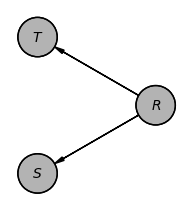

In [33]:
pgm.model.to_daft().render()

In [34]:
states = pgm.get_states()
states.Rain.LIGHT_RAIN.value

60

In [35]:
states.Traffic.HEAVY.name

'HEAVY'

In [36]:
variables = pgm.get_variables()
variables.Rain
variables.Traffic

'T'

In [37]:
res = pgm.predict_dist(
    [variables.Traffic, variables.Speed], 
    evidence={variables.Rain: states.Rain.LIGHT_RAIN.name})
print(res)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+----------+---------+------------+
| T        | S       |   phi(T,S) |
+==========+=========+============+
| T(LOW)   | S(LOW)  |     0.2400 |
+----------+---------+------------+
| T(LOW)   | S(HIGH) |     0.1600 |
+----------+---------+------------+
| T(HEAVY) | S(LOW)  |     0.3600 |
+----------+---------+------------+
| T(HEAVY) | S(HIGH) |     0.2400 |
+----------+---------+------------+


In [4]:
res = pgm.predict_state(['T'], evidence={'R': states.Rain.HEAVY_RAIN.name})
res

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


{'T': 'LOW'}

In [11]:
states.Traffic['LOW'].value

10